In [131]:
import sys
import os

# Add project root to the system path
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../"))
if project_root not in sys.path:
    sys.path.append(project_root)

In [132]:
import numpy as np
import random
import pandas as pd

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

FEATURES_NAMES = [
    "original_index",
    "original_grid-load_trend-strength",
    "original_grid-load_trend-slope",
    "original_grid-load_trend-linearity",
    "original_grid-load_seasonal-strength",
    "original_grid-loss_trend-strength",
    "original_grid-loss_trend-slope",
    "original_grid-loss_trend-linearity",
    "original_grid-loss_seasonal-strength",
    "original_grid-temp_trend-strength",
    "original_grid-temp_trend-slope",
    "original_grid-temp_trend-linearity",
    "original_grid-temp_seasonal-strength",
    "delta_grid-load_trend-strength",
    "delta_grid-load_trend-slope",
    "delta_grid-load_trend-linearity",
    "delta_grid-load_seasonal-strength",
    "delta_grid-loss_trend-strength",
    "delta_grid-loss_trend-slope",
    "delta_grid-loss_trend-linearity",
    "delta_grid-loss_seasonal-strength",
    "delta_grid-temp_trend-strength",
    "delta_grid-temp_trend-slope",
    "delta_grid-temp_trend-linearity",
    "delta_grid-temp_seasonal-strength",
]

TARGET_NAMES = [
    "target_grid-load_trend-strength",
    "target_grid-load_trend-slope",
    "target_grid-load_trend-linearity",
    "target_grid-load_seasonal-strength",
    "target_grid-loss_trend-strength",
    "target_grid-loss_trend-slope",
    "target_grid-loss_trend-linearity",
    "target_grid-loss_seasonal-strength",
    "target_grid-temp_trend-strength",
    "target_grid-temp_trend-slope",
    "target_grid-temp_trend-linearity",
    "target_grid-temp_seasonal-strength",
]

# Loading experiment parameters

In [134]:
from src.utils.yaml_loader import read_yaml

settings = read_yaml('../../experiments/gridloss/naive_correlation.yml')
settings

{'dataset_args': {'directory': '/Users/vegardsjavik/Uni/Master/Thesis/BEAST/data/gridloss',
  'training_data': 'train.csv',
  'test_data': 'test.csv',
  'window_size': 168,
  'step_size': 24,
  'timeseries_to_use': ['grid1-load', 'grid1-temp', 'grid1-loss']},
 'forecasting_model_args': {'window_size': 168,
  'network_size': [100, 100],
  'horizon_length': 24,
  'model_name': 'feedforward_forecaster',
  'learning_rate': 0.001},
 'training_args': {'log_to_wandb': True}}

In [135]:
features_to_use = settings['dataset_args']['timeseries_to_use']
data_dir = os.path.join(settings['dataset_args']['directory'], 'train.csv')
step_size = settings['dataset_args']['step_size']


window_size = settings['forecasting_model_args']['window_size']
horizon_length = settings['forecasting_model_args']['horizon_length']
learning_rate = settings['forecasting_model_args']['learning_rate']

input_size = window_size*len(features_to_use)
output_size = horizon_length

# Loading pretrained forecasting model

In [136]:
from src.models.forecasting.feedforward import FeedForwardForecaster

model = FeedForwardForecaster(
    input_size=input_size,
    output_size=output_size,
    save_dir=''
)

# Loading data

In [137]:
df = pd.read_csv(data_dir, index_col=0)
df.index = pd.to_datetime(df.index)
df = df[features_to_use]
df = df.bfill()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17520 entries, 2017-12-01 00:00:00 to 2019-11-30 23:00:00
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   grid1-load  17520 non-null  float64
 1   grid1-temp  17520 non-null  float64
 2   grid1-loss  17520 non-null  float64
dtypes: float64(3)
memory usage: 547.5 KB


## Creating windows of dataset

In [138]:
from src.utils.generate_dataset import generate_windows_dataset

num_ts = len(features_to_use)
dataset_size = (df.shape[0] - window_size)//step_size + 1

data = generate_windows_dataset(df, window_size, step_size, features_to_use)

100%|██████████| 724/724 [00:00<00:00, 92123.78it/s]


## Calculate features

In [139]:
from src.utils.generate_dataset import generate_feature_dataframe

sp = 24 # STL parameter

feature_df = generate_feature_dataframe(
    data=data, series_periodicity=sp, dataset_size=dataset_size
)

100%|██████████| 724/724 [00:04<00:00, 175.09it/s]


## PCA

In [140]:
from src.utils.pca import PCAWrapper

pca_transformer = PCAWrapper()
mts_pca_df = pca_transformer.fit_transform(feature_df)


# Splitting into train/test 
We use the PCA plot to simply split the data into a distinct training and test dataset. The test dataset is where we want to transform the MTS into.

2025-02-18 09:33:29,277 - INFO - Generating X, y pairs for train, validation, and test sets...
2025-02-18 09:33:29,280 - INFO - Found 62 outliers
2025-02-18 09:33:29,281 - INFO - Generating supervised training dataset...
2025-02-18 09:35:09,778 - INFO - Generating supervised validation dataset...
2025-02-18 09:35:13,921 - INFO - Generating supervised test dataset...
2025-02-18 09:35:19,417 - INFO - Generated PCA plot with target/test pairing
2025-02-18 09:35:19,418 - INFO - Generating X, y pairs for training dataset...
2025-02-18 09:35:19,470 - INFO - Generating X, y pairs for validation dataset...
2025-02-18 09:35:19,473 - INFO - Generating X, y pairs for test dataset...
2025-02-18 09:35:19,475 - INFO - Generated X, y pairs with shapes:
X_train: (1312746, 25), y_train: (1312746, 12)
X_validation: (61566, 25), y_validation: (61566, 12)
X_test: (61566, 25), y_test: (61566, 12)


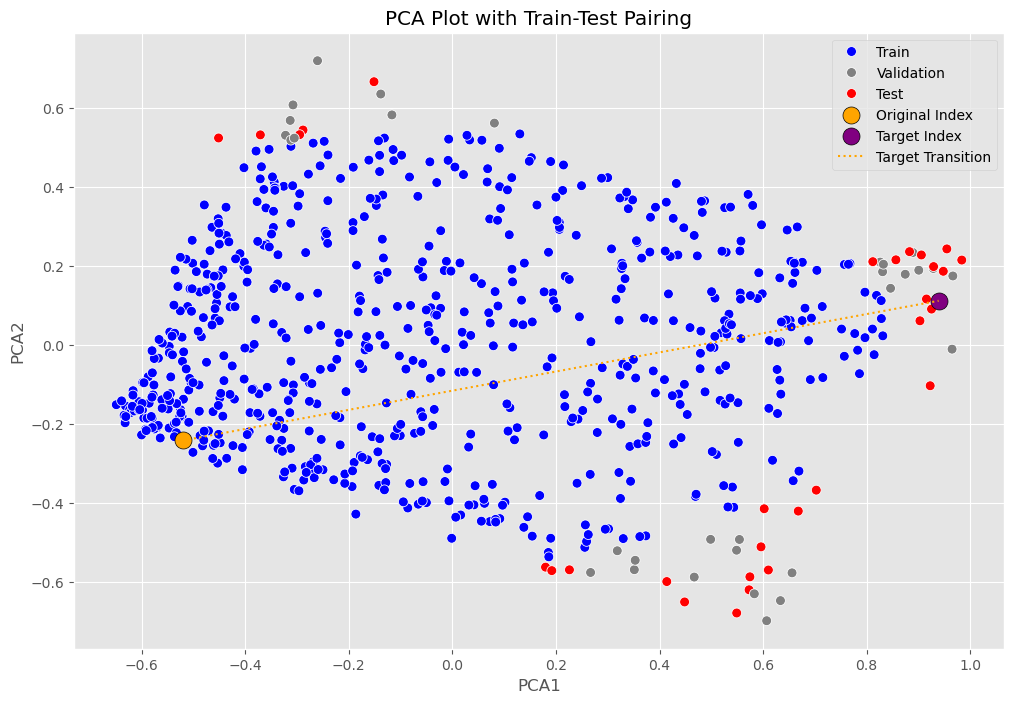

In [141]:
from src.data_transformations.generation_of_supervised_pairs import create_train_val_test_split_outliers

(
    X_train,
    y_train,
    X_validation,
    y_validation,
    X_test,
    y_test,
    train_supervised_dataset,
    validation_supervised_dataset,
    test_supervised_dataset,
) = create_train_val_test_split_outliers(
    pca_df=mts_pca_df,
    feature_df=feature_df,
    FEATURES_NAMES=FEATURES_NAMES,
    TARGET_NAMES=TARGET_NAMES,
    SEED=SEED,
    output_dir=''
)

## Correlation analysis
We then check the correlation values between the different features.

We then plot the correlation values.

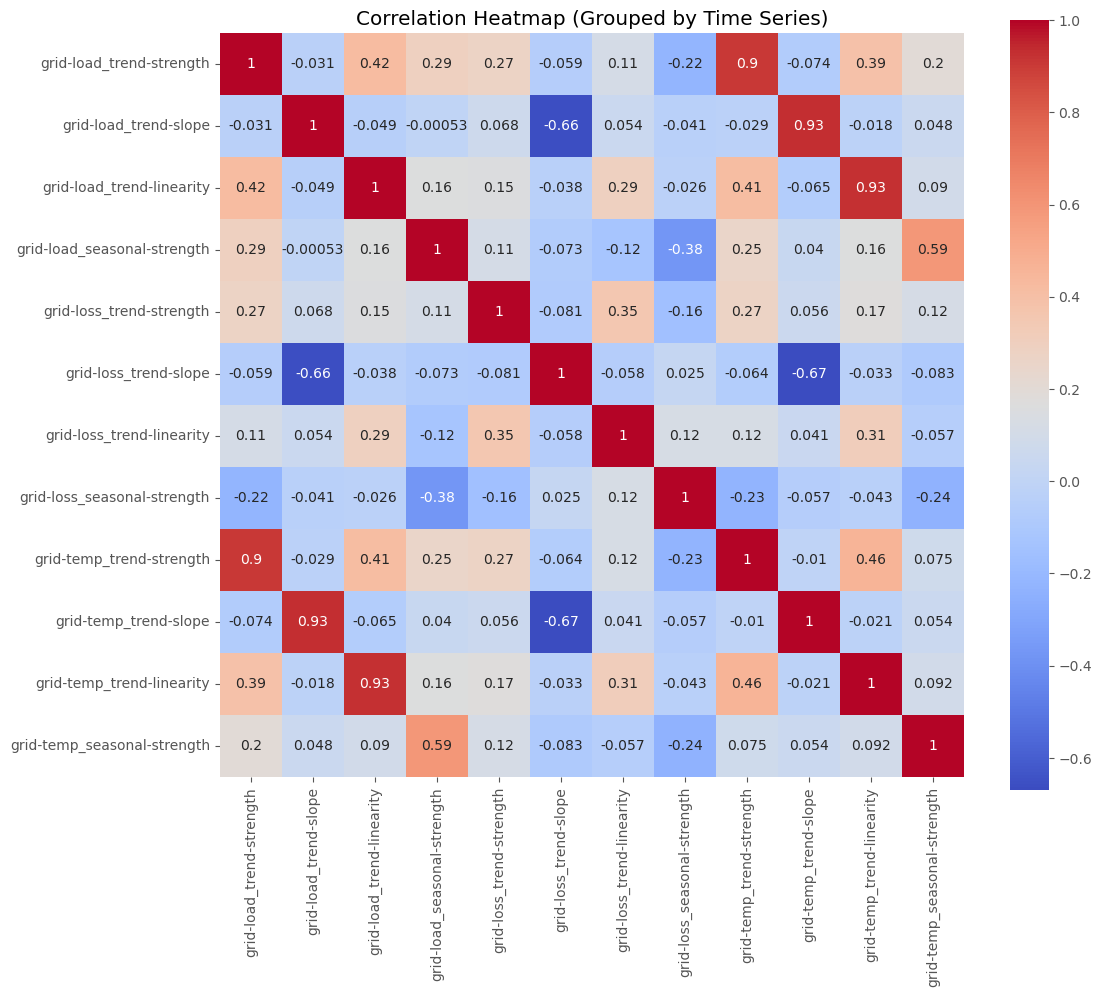

In [142]:
import seaborn as sns
from matplotlib import pyplot as plt


corr_matrix = feature_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)
plt.title("Correlation Heatmap (Grouped by Time Series)")
plt.show()


# Analysing training set

100%|██████████| 36/36 [00:41<00:00,  1.16s/it]


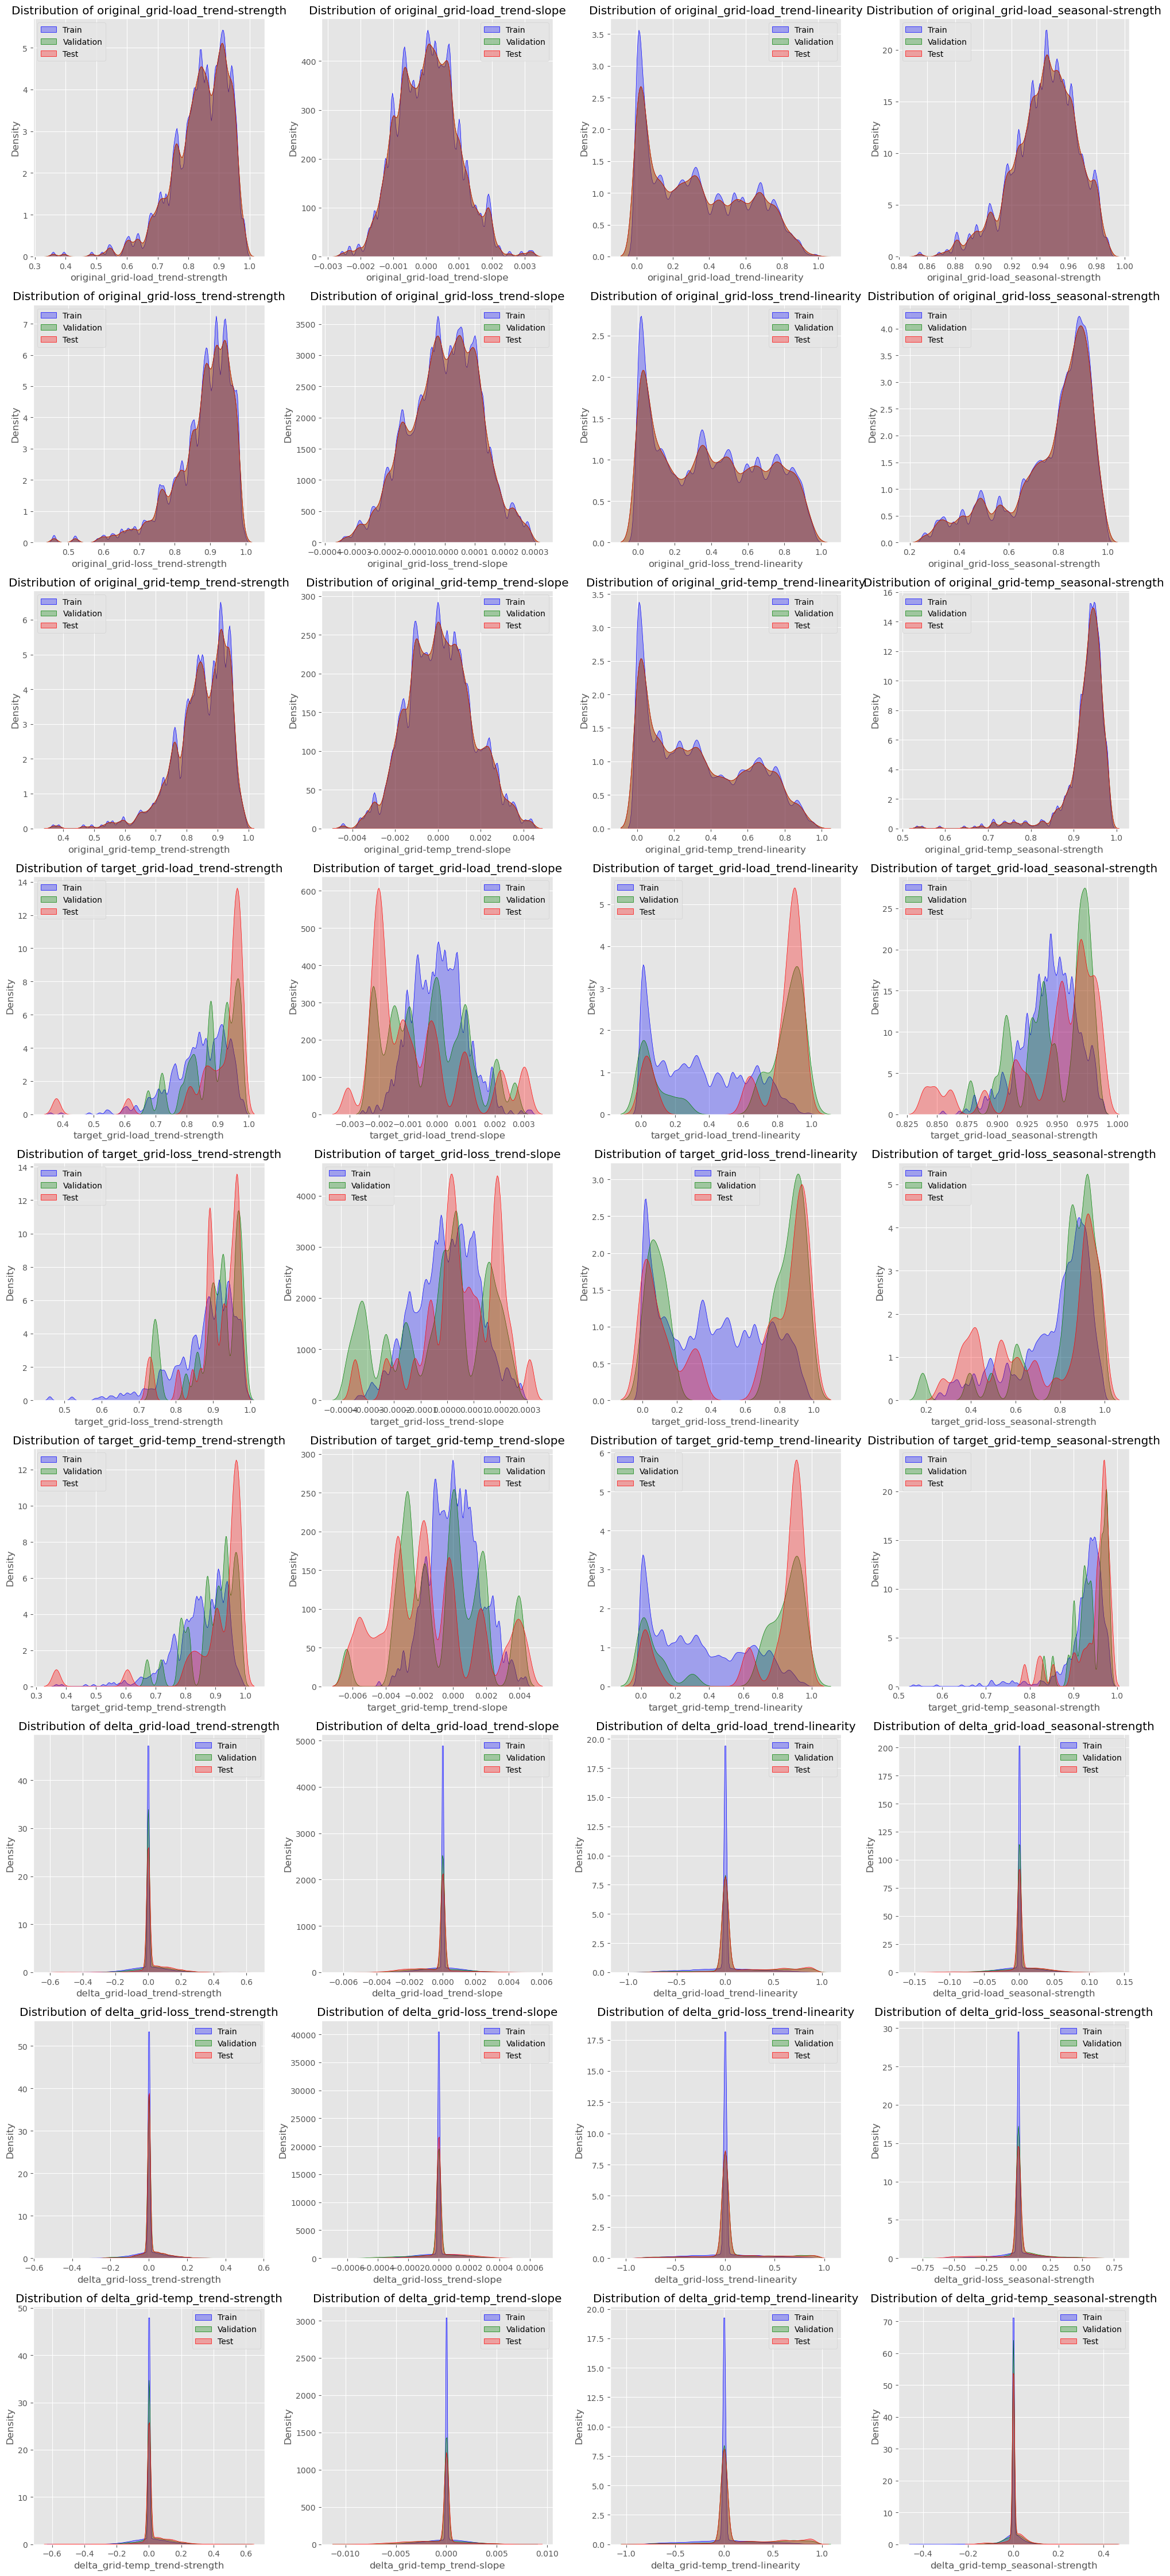

In [143]:
import math
from tqdm import tqdm

columns = [col for col in train_supervised_dataset.columns if col not in ['original_index', 'target_index', 'delta_index']]

# Define grid size
n_cols = 4  # Number of columns in the grid
n_rows = math.ceil(len(columns) / n_cols)  # Calculate required rows

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))  
axes = axes.flatten()  # Flatten axes array to easily iterate

# Loop through each column and plot on the grid
for i, col in tqdm(enumerate(columns), total=len(columns)):
    ax = axes[i]
    
    # Plot KDE distributions
    sns.kdeplot(train_supervised_dataset[col], label='Train', color='blue', fill=True, alpha=0.3, ax=ax)
    sns.kdeplot(validation_supervised_dataset[col], label='Validation', color='green', fill=True, alpha=0.3, ax=ax)
    sns.kdeplot(test_supervised_dataset[col], label='Test', color='red', fill=True, alpha=0.3, ax=ax)
    
    # Titles and labels
    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Density")
    ax.legend()

# Remove empty subplots (if any)
for i in range(len(columns), len(axes)):
    fig.delaxes(axes[i])  # Delete extra axes

# Adjust layout
plt.tight_layout()
plt.show()

# Training correlation model
We then build a correlation model. Using the previous correlation values, this model is intended to mathematically guess the new feature values based on the current ones and changes to one feature value. This is done like this:
1. Get the delta to the changed feature.
2. Get the correlation the changed feature has with all other features.
3. For each feature calulcate new feature value: $$New = value + delta * correlation factor $$

## Running inference through correlation model
First we use the training data to train the model

In [287]:
import pandas as pd
import numpy as np
from tqdm import tqdm


class CorrelationModel:
    def train(self, training_set):
        """
        To train the model, we calculate the correlations between the time series features
        in the training set.
        """
        self.correlations = training_set.corr()



    def infer(self, values):
        """
        Inference of the model is based on a naive correlation assumption.
        We change all other features except the one that is transformed.
        To do this, we record the delta of the original transformation. We then
        update each feature by adding this delta multiplied with the correlation factor between the features.
        """
        updated_values = values.copy(deep=True)

        # Keep only the necessary columns
        columns_to_keep = [col for col in updated_values.columns if col.startswith("original_") or col.startswith("delta_")]
        updated_values = updated_values[columns_to_keep]

        # Extract delta and original columns
        delta_columns = [col for col in updated_values.columns if col.startswith("delta_")]
        features_without_appendices = []

        for delta_column in delta_columns:
            features_without_appendices.append(delta_column[len('delta_') :])
        original_columns = [col for col in updated_values.columns if col.startswith("original_") and col != "original_index"]

        # Create a DataFrame for predictions
        predictions = pd.DataFrame(index=updated_values.index, columns=[col[len("original_"):] for col in original_columns])

        for jaja, row in tqdm(updated_values.iterrows(), total=len(updated_values)):
            # Create a boolean mask for nonzero delta values
            mask = abs(row[delta_columns]) > 0.0

            # Ensure index alignment using .loc
            filtered_series = row[delta_columns][mask]

            timeseries_transformed = filtered_series.index[0].split('_')[1]

            # Get vector of delta values for said time series
            delta_values_for_transformed_timeseries = row.filter(like=f'delta_{timeseries_transformed}')
            
            # TODO: Iterate over each delta value, using the correlations to predict for each time series.
            for delta_column in delta_values_for_transformed_timeseries.index:
                delta_correlations = self.correlations[delta_column[len('delta_'):]].filter(like=delta_column.split('_')[-1])
                for correlation_column in delta_correlations.index:
                    predictions.at[jaja, correlation_column] = row[f'original_{correlation_column}'] + row[f'delta_{correlation_column}'] * delta_correlations[correlation_column]



        # Apply clipping conditions
        predictions = predictions.clip(lower=0, upper=1)
        predictions.loc[:, predictions.columns.str.contains("trend-slope")] = predictions.loc[:, predictions.columns.str.contains("trend-slope")].clip(-1, 1)

        # Add prediction index
        predictions["prediction_index"] = predictions.index.astype(int)

        return predictions

In [288]:
correlation_model = CorrelationModel()
correlation_model.train(feature_df)

Then we run inference through the logic developed in the correlation model

In [289]:
predictions_validation = correlation_model.infer(validation_supervised_dataset)
predictions_test = correlation_model.infer(test_supervised_dataset)

100%|██████████| 61566/61566 [00:34<00:00, 1777.09it/s]


In [290]:
predictions_validation

,grid-load_trend-strength,grid-load_trend-slope,grid-load_trend-linearity,grid-load_seasonal-strength,grid-loss_trend-strength,grid-loss_trend-slope,grid-loss_trend-linearity,grid-loss_seasonal-strength,grid-temp_trend-strength,grid-temp_trend-slope,grid-temp_trend-linearity,grid-temp_seasonal-strength,prediction_index
0,0.973451,0,0.990389,0.975518,0.945474,0.000073,0.1405,0.375897,0.849588,0,0.19425,0.933,0
1,0.862437,0,0.185495,0.944772,0.933319,0.000211,0.759634,0.862505,0.849588,0,0.19425,0.933,1
2,0.862437,0,0.185495,0.944772,0.945474,0.000073,0.1405,0.375897,0.976045,0,0.990358,0.976605,2
3,0.806893,0,0.005849,0.947623,0.945474,0.000073,0.1405,0.375897,0.849588,0,0.19425,0.933,3
4,0.862437,0,0.185495,0.944772,0.898419,0.000165,0.965671,0.918486,0.849588,0,0.19425,0.933,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61561,0.817407,0.00063,0.644919,0.971124,0.746585,0.000027,0.155224,0.922809,0.823398,0.001109,0.65613,0.969848,61561
61562,0.817407,0.00063,0.644919,0.971124,0.903319,0,0.769807,0.487631,0.904973,0,0.868063,0.968115,61562
61563,0.714888,0,0.008982,0.937303,0.903319,0,0.769807,0.487631,0.823398,0.001109,0.65613,0.969848,61563
61564,0.817407,0.00063,0.644919,0.971124,0.929829,0,0.847937,0.845733,0.823398,0.001109,0.65613,0.969848,61564


/var/folders/t1/cjrcl1s578gdksfbv787y8x40000gn/T/ipykernel_33257/2525083318.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


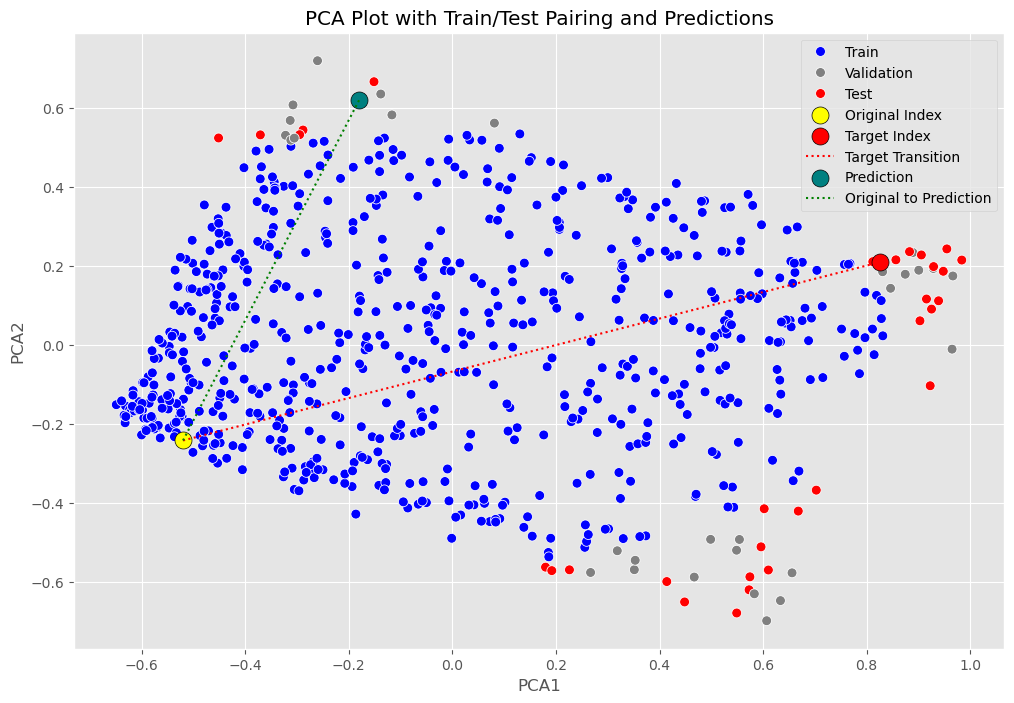

In [291]:

from src.plots.pca_train_test_pairing import pca_plot_train_test_pairing_with_one_prediction


predictions_without_index = predictions_validation.drop(columns=["prediction_index"])
predictions_pca = pca_transformer.transform(predictions_without_index)
predictions_validation["pca1"] = predictions_pca["pca1"]
predictions_validation["pca2"] = predictions_pca["pca2"]
prediction = predictions_validation.sample(n=1, random_state=SEED).reset_index(
    drop=True
)
index = prediction["prediction_index"][0]
dataset_row = validation_supervised_dataset.loc[index]
fig = pca_plot_train_test_pairing_with_one_prediction(
    mts_pca_df, dataset_row, prediction
)
fig.show()

# Analysis of results

## Model error analysis
We then look at which features the model does well on, and which it does not do well on. 

In [292]:
from src.utils.evaluation.feature_space_evaluation import find_error_of_each_feature_for_each_sample


differences_df_validation = find_error_of_each_feature_for_each_sample(
    predictions=predictions_validation,
    labelled_test_dataset=validation_supervised_dataset,
)
differences_df_test = find_error_of_each_feature_for_each_sample(
    predictions=predictions_test, labelled_test_dataset=test_supervised_dataset
)

100%|██████████| 61566/61566 [00:10<00:00, 5777.55it/s]


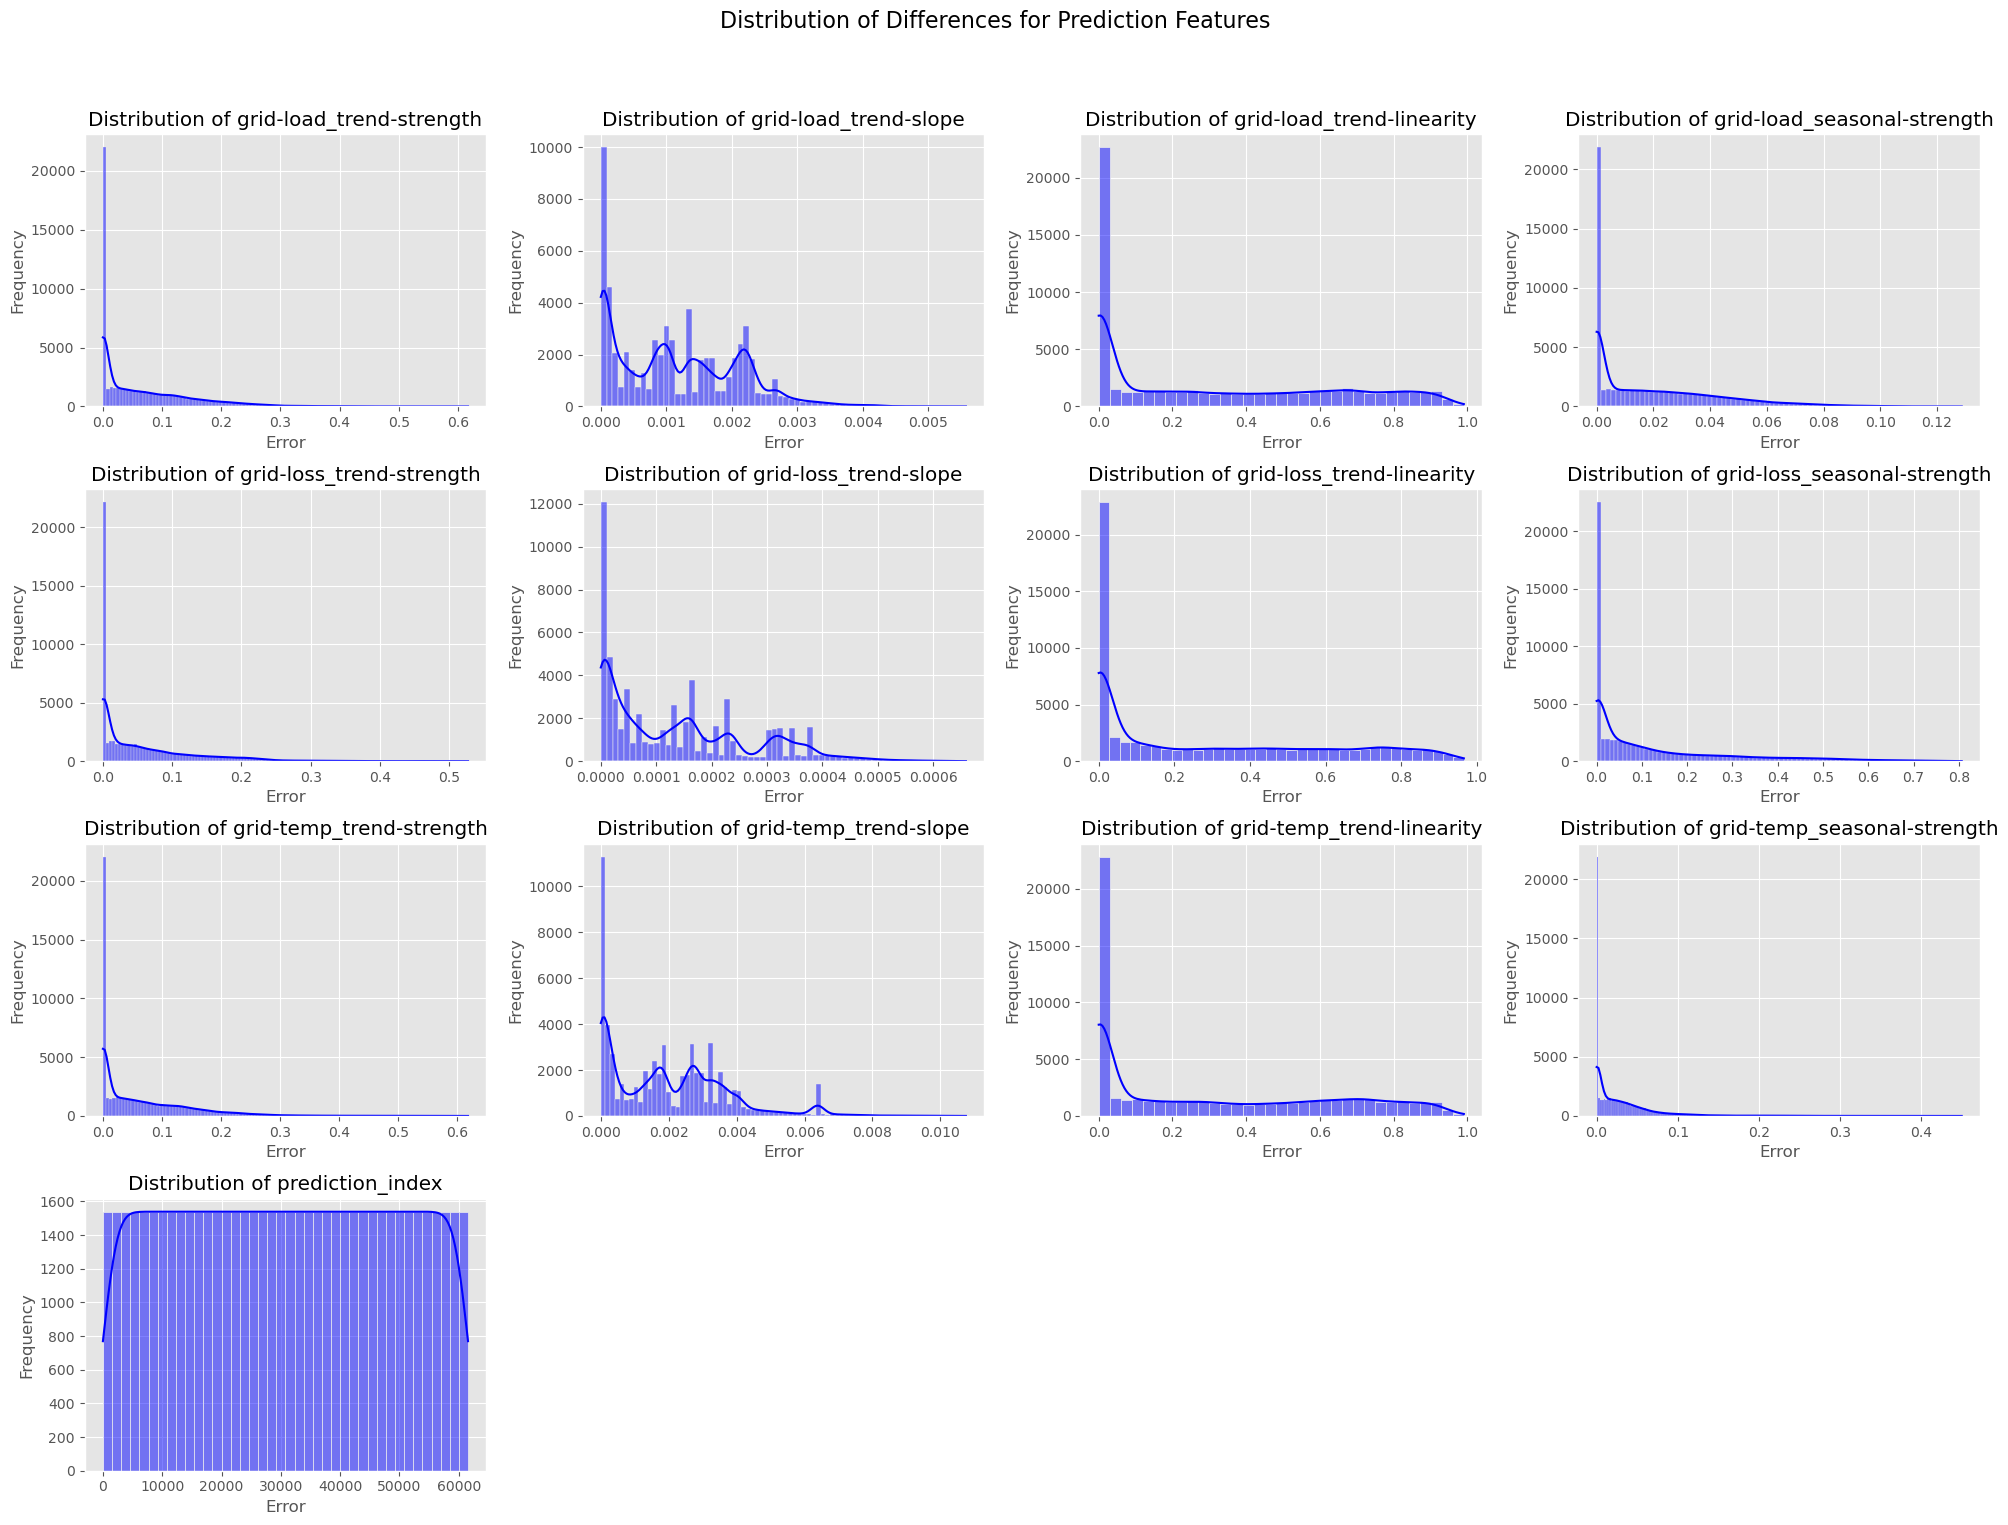

In [293]:
from src.plots.feature_wise_error import plot_distribution_of_feature_wise_error


fig = plot_distribution_of_feature_wise_error(differences_df_validation)

In [294]:
from src.utils.evaluation.mse import get_mse_for_features_and_overall


overall_mse_validation, mse_values_for_each_feature_validation = (
    get_mse_for_features_and_overall(differences_df_validation)
)
overall_mse_test, mse_values_for_each_feature_test = get_mse_for_features_and_overall(
    differences_df_test
)

print(
    f"Overall MSE for model\nValidation: {overall_mse_validation}\nTest: {overall_mse_test}"
)

2025-02-18 10:48:57,986 - INFO - Calculating MSE for each feature
2025-02-18 10:48:57,990 - INFO - Calculating overall MSE
2025-02-18 10:48:57,991 - INFO - Calculating MSE for each feature
2025-02-18 10:48:57,993 - INFO - Calculating overall MSE


Overall MSE for model
Validation: 0.053945157847569834
Test: 0.05970482680170024


As we can see, the model clearly has issues with trend linearity. These are also the most important features for the PCA plot. This is probably because the PCA plot uses the the features with the highest variance as its components. This causes the vizualization to break down on the predictions, while the model itself might be quite good.

### Why the model predicts the wrong direction

In [295]:
pca_correlation_df = feature_df.copy()
pca_correlation_df['pca1'] = mts_pca_df['pca1']
pca_correlation_df['pca2'] = mts_pca_df['pca2']

In [296]:
pca_corr = pca_correlation_df.corr()[['pca1', 'pca2']].T.drop(columns=['pca1', 'pca2'])
pca_corr.T

,pca1,pca2
grid-load_trend-strength,0.429486,-0.166857
grid-load_trend-slope,-0.015144,0.070511
grid-load_trend-linearity,0.944234,-0.259904
grid-load_seasonal-strength,0.123125,-0.259872
grid-loss_trend-strength,0.260903,0.255516
grid-loss_trend-slope,-0.050158,-0.034150
grid-loss_trend-linearity,0.543153,0.835680
grid-loss_seasonal-strength,-0.009820,0.245500
grid-temp_trend-strength,0.460875,-0.174502
grid-temp_trend-slope,-0.027545,0.061648


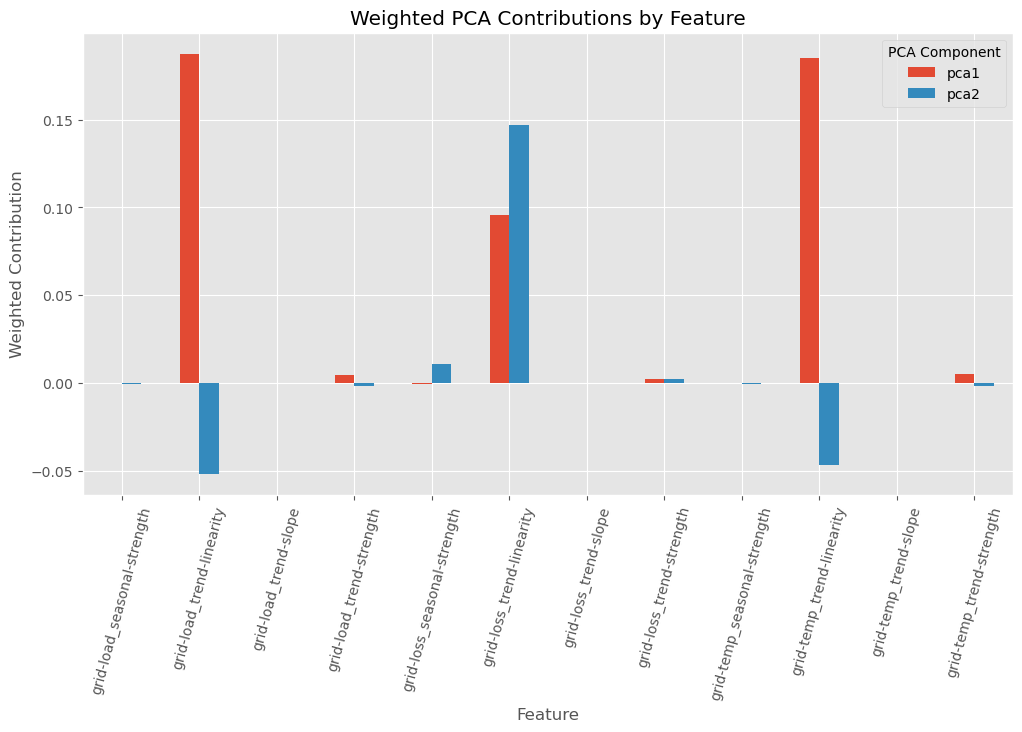

In [297]:

# Weighted PCA values
weighted_pca = pca_corr.multiply(mse_values_for_each_feature_validation, axis=1)

# Bar Plot
weighted_pca.T.plot(kind="bar", figsize=(12, 6))
plt.title("Weighted PCA Contributions by Feature")
plt.ylabel("Weighted Contribution")
plt.xlabel("Feature")
plt.legend(title="PCA Component")
plt.xticks(rotation=75)
plt.show()

## Tracing the worst prediction
We then trace the worst prediction made, to figure out why this prediction is made.

In [298]:
def get_error_for_each_row(differences_df):

    # Excluding 'prediction_index' without explicit dropping
    feature_columns = differences_df.columns.difference(["prediction_index"])

    differences_df['total_error'] = differences_df[feature_columns].sum(axis=1)

    return differences_df[['prediction_index', 'total_error']]

total_error_rowwise_validation = get_error_for_each_row(differences_df_validation)

In [299]:
worst_prediction_validation = total_error_rowwise_validation.loc[total_error_rowwise_validation['total_error'].idxmax()]['prediction_index']
worst_prediction_validation

57196.0

/var/folders/t1/cjrcl1s578gdksfbv787y8x40000gn/T/ipykernel_33257/2622980994.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


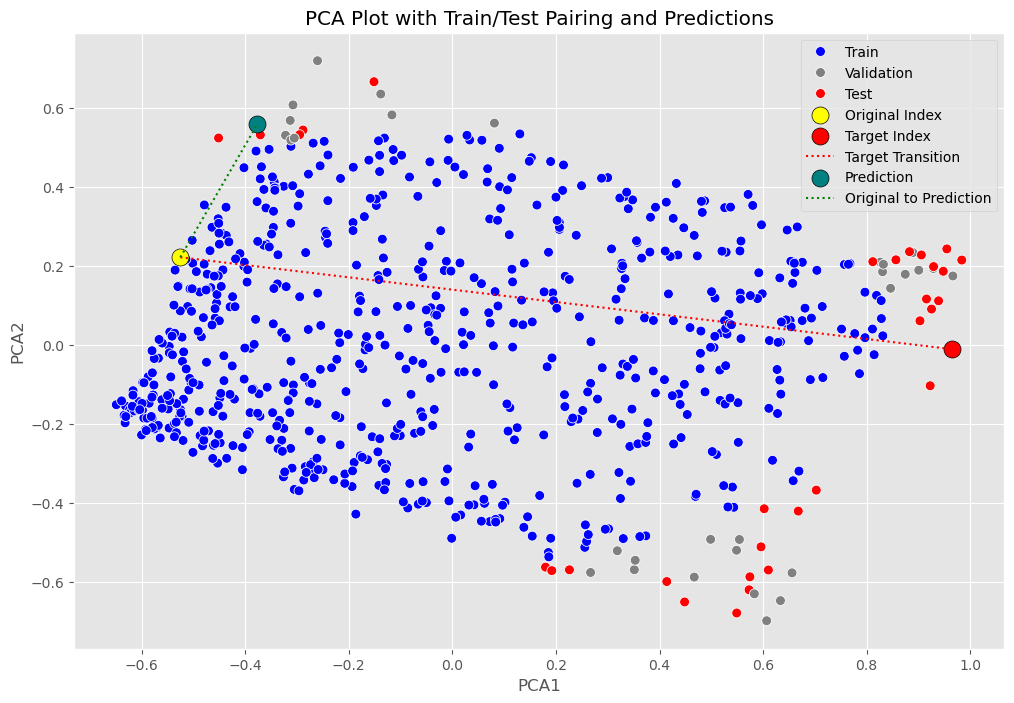

In [300]:
worst_prediction = predictions_validation[predictions_validation['prediction_index'] == worst_prediction_validation].reset_index(drop=True)
index = worst_prediction_validation
dataset_row = validation_supervised_dataset.loc[index]
fig = pca_plot_train_test_pairing_with_one_prediction(
    mts_pca_df, dataset_row, worst_prediction
)
fig.show()

In [301]:
worst_prediction_supervised_row = validation_supervised_dataset.iloc[[int(worst_prediction_validation)]].reset_index(drop=True)

/var/folders/t1/cjrcl1s578gdksfbv787y8x40000gn/T/ipykernel_33257/1866669285.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
/var/folders/t1/cjrcl1s578gdksfbv787y8x40000gn/T/ipykernel_33257/1866669285.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[3].set_xticklabels(axes[3].get_xticklabels(), rotation=90, ha="right")


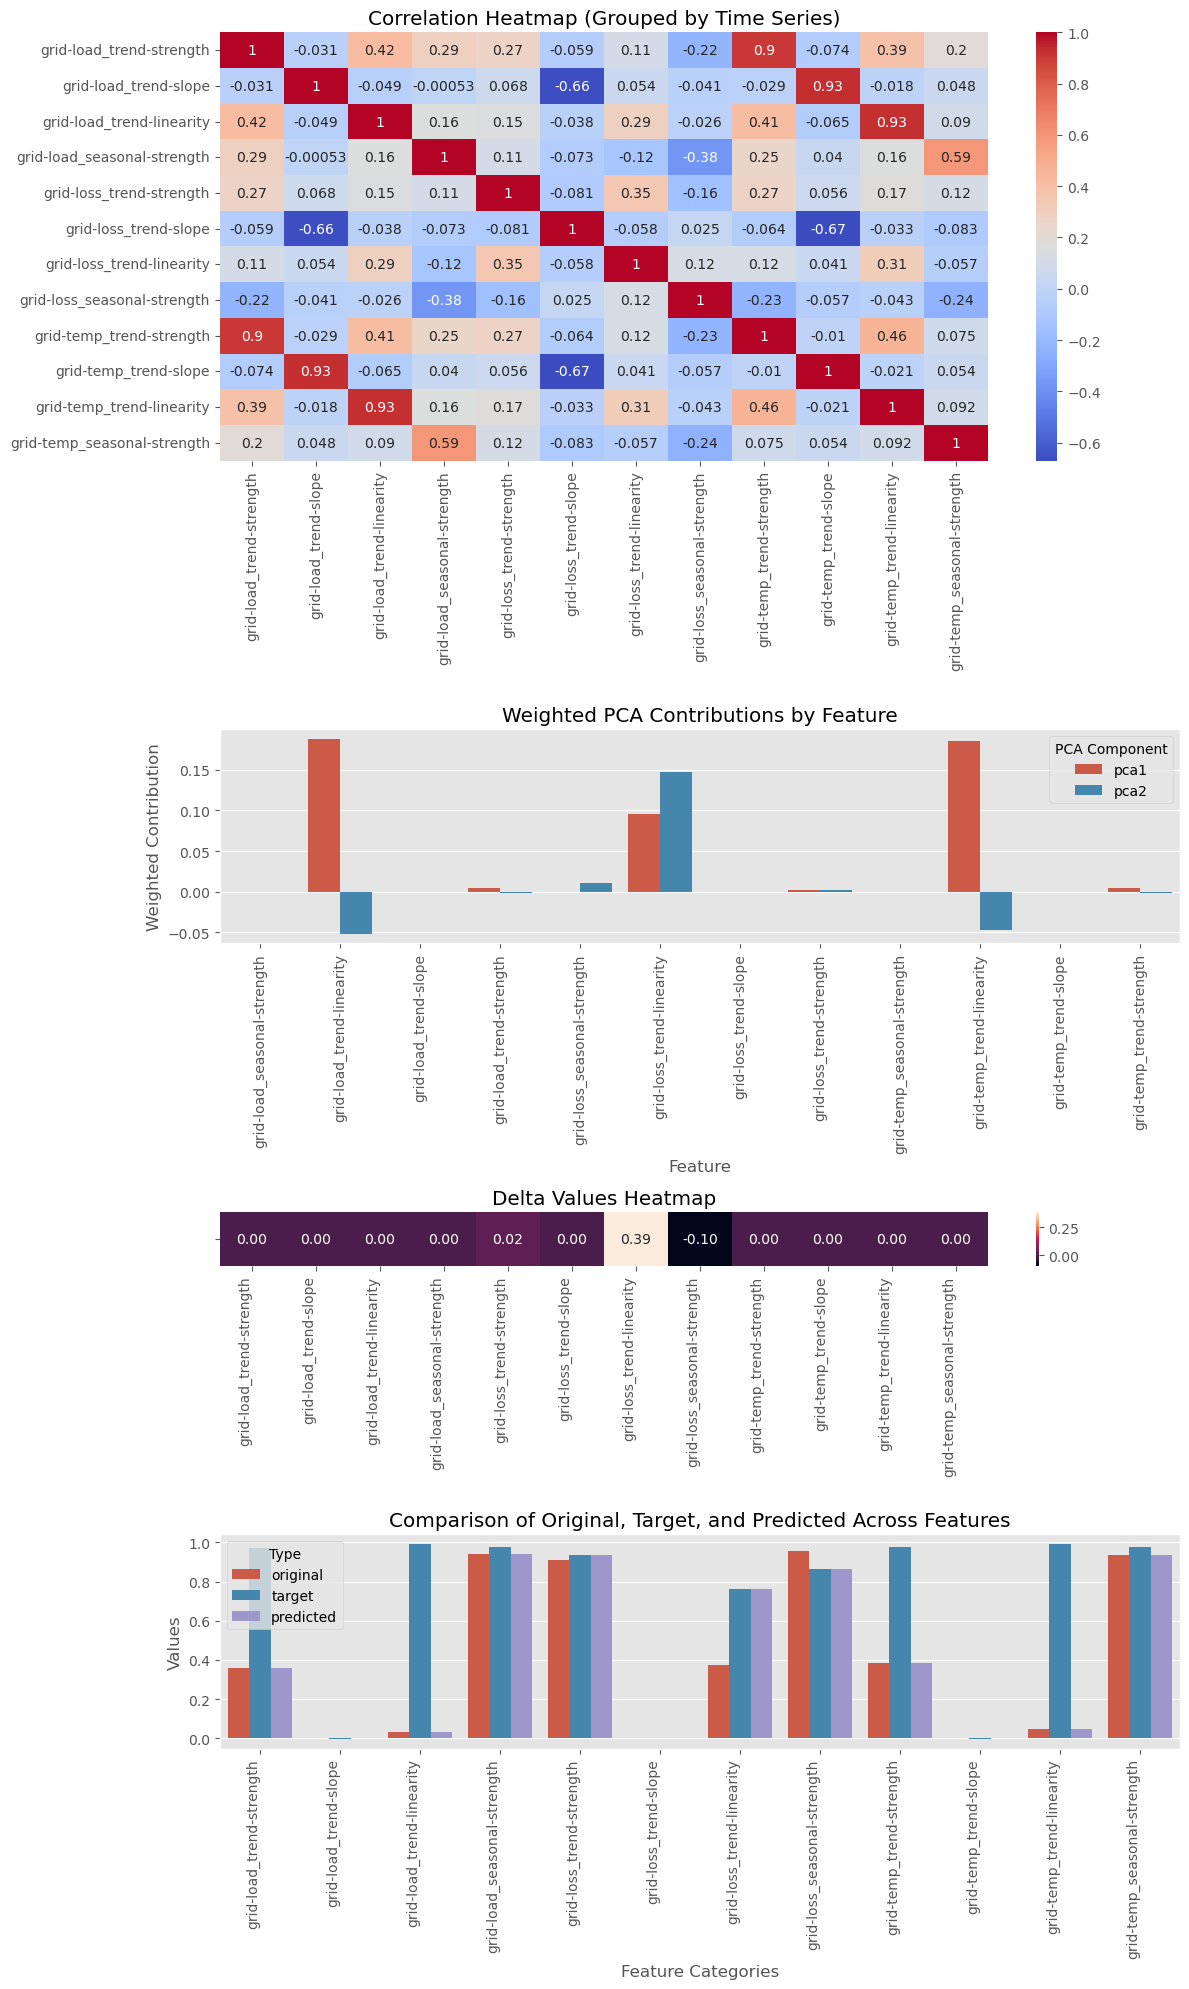

In [303]:
from collections import OrderedDict

# Remove 'pca1' and 'pca2' from worst_prediction, then rename columns with 'predicted_' prefix
worst_prediction_tmp = worst_prediction.drop(columns=['pca1', 'pca2'], errors='ignore').add_prefix("predicted_")

# Join the two DataFrames (assuming they have the same index)
worst_combined = pd.concat([worst_prediction_supervised_row, worst_prediction_tmp], axis=1)

# Drop index columns if they exist
worst_combined = worst_combined.drop(columns=[col for col in worst_combined.columns if 'index' in col], errors='ignore')

# Separate delta columns for heatmap
delta_cols = [col for col in worst_combined.columns if "delta_" in col]  # Preserve order
delta_df = worst_combined[delta_cols]

# Remove delta columns from the main DataFrame for bar plot
worst_combined = worst_combined.drop(columns=delta_cols)

# Maintain category order based on appearance in DataFrame
categories = OrderedDict.fromkeys([col.split('_', 1)[1] for col in worst_combined.columns])

melted_df = pd.DataFrame()

for cat in categories.keys():
    subset = worst_combined.filter(like=cat)  # Get columns related to this category
    temp_df = subset.melt(var_name="Type", value_name="Value")
    temp_df["Category"] = cat
    melted_df = pd.concat([melted_df, temp_df])

# Extract the labels (original, target, predicted) for coloring
melted_df["Type"] = melted_df["Type"].str.split('_').str[0]

# Reorder categories in melted_df to match heatmap order
melted_df["Category"] = pd.Categorical(melted_df["Category"], categories=list(categories.keys()), ordered=True)

# Sort by category order
melted_df = melted_df.sort_values("Category")

# Create Subplots
fig, axes = plt.subplots(nrows=4, figsize=(12, 20), gridspec_kw={'height_ratios': [8, 4, 1, 4]})



sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=False, ax=axes[0])
axes[0].set_title("Correlation Heatmap (Grouped by Time Series)")


# Reset index and melt for seaborn
weighted_pca_melted = weighted_pca.reset_index().melt(id_vars="index", var_name="Feature", value_name="Weighted Contribution")

# Rename for clarity
weighted_pca_melted.rename(columns={"index": "PCA Component"}, inplace=True)

# Bar Plot using seaborn
sns.barplot(x="Feature", y="Weighted Contribution", hue="PCA Component", data=weighted_pca_melted, ax=axes[1])

axes[1].set_title("Weighted PCA Contributions by Feature")
axes[1].set_ylabel("Weighted Contribution")
axes[1].set_xlabel("Feature")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)

# Heatmap for delta values
sns.heatmap(delta_df, annot=True, fmt=".2f", ax=axes[2])
axes[2].set_title("Delta Values Heatmap")
axes[2].set_xticklabels([col.replace("delta_", "") for col in delta_df.columns], rotation=90, ha="right")
axes[2].set_yticklabels([])  # Hide y-axis labels

# Bar plot for original, target, and predicted values
sns.barplot(x="Category", y="Value", hue="Type", data=melted_df, ax=axes[3])
axes[3].set_xticklabels(axes[3].get_xticklabels(), rotation=90, ha="right")
axes[3].set_xlabel("Feature Categories")
axes[3].set_ylabel("Values")
axes[3].set_title("Comparison of Original, Target, and Predicted Across Features")

# Adjust layout
plt.tight_layout()
plt.show()